# Main functions used in experiments

In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [2]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()
env??

Type:            WindyGridworldEnv
String form:     <WindyGridworldEnv instance>
File:            ~/Documents/Master AI/Reinforcement Learning/RL_reproducibility/windy_gridworld.py
Source:         
class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 1

## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [3]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains 
        a probability of perfoming action in given state for every corresponding state action pair. 

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """   
        
        # Inefficient but kept same structure as below if we change policy later
        probs = [1 if a == np.argmax(self.Q[s]) else 0 for s,a in zip(states, actions)]
        
        return probs
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        # find out what the max action is
        best_action = np.argmax(self.Q[obs])
        
        return best_action

In [4]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, states, actions):
        # loop over the state action lists and compute probabilities according to eps greedy
        probs = [1-self.epsilon if a == np.argmax(Q[s]) else self.epsilon/self.Q.shape[0] for s, a in zip(states, actions)]
                
        return probs
        
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
         
        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 
        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice(best_actions)
        else:
            # return a random action
            action = np.random.randint(0,4)
                
        return action


### Behavioural policy
Random policy from blackjack lab. 
TODO: experiment with behavioural policies to check which yield interesting results

In [5]:
class RandomPolicy(object):
    """
    A behavioural policy
    """
    def __init__(self, nS, nA):
        self.probs = np.ones((nS, nA)) * 1/nA
        
    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains 
        a probability of perfoming action in given state for every corresponding state action pair. 

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """        
        probs = [self.probs[s,a] for s,a in zip(states, actions)]
        
        return probs

    
    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            state: current state

        Returns:
            An action (int).
        """
        p_s = self.probs[state]
        
        return np.random.choice(range(0,self.probs.shape[1]), p=p_s)

In [6]:
random_policy = RandomPolicy(env.nS, env.nA)

## Monte Carlo

## Sampling function given an env and policy
Function to sample an episode from the env.

In [7]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [8]:
# check the length of episodes that are generated for random policy
for episode in range(10):
    trajectory_data = sample_episode(env, random_policy)
#     print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))
    print(f"length of episode {episode}: {len(trajectory_data[0])}")


length of episode 0: 3076
length of episode 1: 4547
length of episode 2: 7833
length of episode 3: 5786
length of episode 4: 7757
length of episode 5: 7943
length of episode 6: 4855
length of episode 7: 3297
length of episode 8: 486
length of episode 9: 3488


In [9]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.nS, env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(10):
    trajectory_data = sample_episode(env, bp)
#     print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 3091
length of episode 1: 13899
length of episode 2: 15418
length of episode 3: 20453
length of episode 4: 4221
length of episode 5: 5116
length of episode 6: 22704
length of episode 7: 7232
length of episode 8: 7727
length of episode 9: 2446


## MC Ordinary Importance Sampling (make it work for windy gridworld)
Status: updated to update Q instead of V

In [10]:
def Qdefaultdict2array(Q, nA, nS):
    Q_np = np.zeros((nS, nA))
    for S in range(nS):
        for A in range(nA):
            Q_np[S][A] = Q[S][A]
    return Q_np
            

In [11]:
def mc_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of current V and count of returns for each state
    # to calculate an update.
    Q = defaultdict(lambda: defaultdict(float))
    returns_count = defaultdict(lambda: defaultdict(float))
    episode_lens = []
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral function:
        behavior_policy = EpsilonGreedyPolicy(Qdefaultdict2array(Q, env.nA, env.nS), epsilon)
        
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states))
        
        # extract target and behavioral probabilities
        target_probs = target_policy.get_probs(states, actions)
        behavioral_probs = behavior_policy.get_probs(states, actions)

        G = 0        
        
        # loop backwards over the trajectory
        for timestep in range(len(states)-1, -1, -1):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            returns_count[s][a] += 1 

            # compute the ratio using the two probability lists
            ratio = np.prod([t/b for t, b in zip(target_probs[timestep:], behavioral_probs[timestep:])])

            # use every visit incremental method
            Q[s][a] += 1/returns_count[s][a] * (ratio * G - Q[s][a])
    
    Q = Qdefaultdict2array(Q, env.nA, env.nS)
    
    return Q, episode_lens

### MC: Weighted Importance Sampling

##### (TODO: Eventually: merge the two functions into one with a weighted flag)

In [12]:
def mc_weighted_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given target policy using behavior policy and weighted importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # create a matrix defaultdict for the Q function and the sum of weights C
    Q = defaultdict(lambda: defaultdict(float))
    C = defaultdict(lambda: defaultdict(float))
    episode_lens = []
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral function:
        behavior_policy = EpsilonGreedyPolicy(Qdefaultdict2array(Q, env.nA, env.nS), epsilon)
        
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save episode lengths
        episode_lens.append(len(states))
        
        # extract target and behavioral probabilities
        target_probs = target_policy.get_probs(states, actions)
        behavioral_probs = behavior_policy.get_probs(states, actions)
        
        # initialize the return and the weight
        G = 0
        W = 1
        
        # loop backwards over the trajectory
        for timestep in range(len(states)-1, -1, -1):            
            # extract info of current timestep from trajectory    
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            # add W to the sum of weights C
            C[s][a] += W
            
            # update Q function incrementally
            Q[s][a] += W/C[s][a] * (G - Q[s][a])
            
            # update the weight
            W *= (target_probs[timestep])/(behavioral_probs[timestep])
            
            # break out of the loop if the weights are 0
            if W == 0:
                break
    
    Q = Qdefaultdict2array(Q, env.nA, env.nS)     
    
    return Q, episode_lens

## Performance
Plot the episode length over training

In [13]:
# Reproducible
np.random.seed(42)

# set other parameters
epsilon = 0.05
discount_factor = 1.0
num_episodes = 40
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths = mc_ordinary_importance_sampling(env, behavioral_policy, target_policy, 
                                                                        num_episodes, discount_factor, epsilon=epsilon)
print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths = mc_weighted_importance_sampling(env, behavioral_policy, target_policy,
                                                                        num_episodes, discount_factor, epsilon=epsilon)

  0%|          | 0/40 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (40 episodes)


  0%|          | 0/40 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (40 episodes)


100%|██████████| 40/40 [01:48<00:00,  2.70s/it]


## Plotting

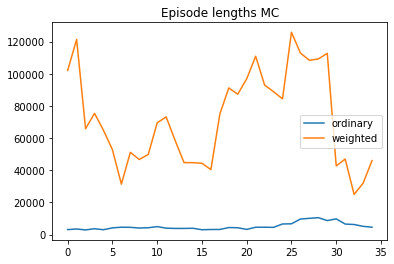

In [14]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

n = 5

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
plt.title('Episode lengths MC')
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

## Temporal Difference

TO-DO: Make N-step

In [26]:
def sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = defaultdict(lambda: defaultdict(float))
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # take action
            s_prime, r, final_state, _ = env.step(a)
            
            # sample action at state s_prime
            a_prime = behavior_policy.sample_action(s_prime)
            
            W = (target_policy.get_probs([s],[a])[0])/(behavior_policy.get_probs([s],[a])[0])

            # update Q 
            Q[s][a] += alpha * W * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
            
            # update current s and a for next iteration
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            # if final state, terminate loop
            if final_state:
                break
            
        stats.append((i, R))
        
    Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [18]:
# Reproducible
np.random.seed(42)

# set other parameters
epsilon = 0.05
discount_factor = 1.0
num_episodes = 40
alpha=0.5
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_td_ordinary, td_ordinary_epsstats = sarsa_ordinary_importance_sampling(env, behavioral_policy, target_policy, 
                                                                        num_episodes, discount_factor, alpha)

  0%|          | 0/40 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (40 episodes)


100%|██████████| 40/40 [00:08<00:00,  4.61it/s]


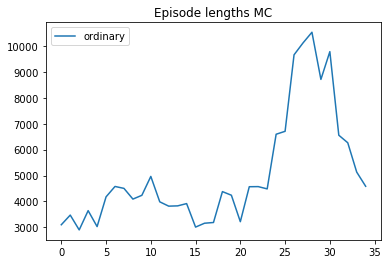

In [20]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

n = 5

plt.plot(running_mean(td_ordinary_epsstats[0], n), label="ordinary")
plt.title('Episode lengths MC')
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

### TO-DO: TD Weighted Importance Sampling (same as above but weighted)

In [ ]:
## TD weighted importance sampling

## Experiments